# let's list the available haarcascades first

`ls /haarcascades/`
***
**`haarcascade_eye.xml`**

`haarcascade_eye_tree_eyeglasses.xml
haarcascade_frontalcatface.xml
haarcascade_frontalcatface_extended.xml
haarcascade_frontalface_alt.xml`

**`haarcascade_frontalface_alt2.xml`**

`haarcascade_frontalface_alt_tree.xml
haarcascade_frontalface_default.xml
haarcascade_fullbody.xml
haarcascade_lefteye_2splits.xml
haarcascade_licence_plate_rus_16stages.xml
haarcascade_lowerbody.xml
haarcascade_profileface.xml
haarcascade_righteye_2splits.xml
haarcascade_russian_plate_number.xml
haarcascade_smile.xml
haarcascade_upperbody.xml
haarcascade_mcs_eyepair_big.xml
haarcascade_mcs_eyepair_small.xml
haarcascade_mcs_leftear.xml
haarcascade_mcs_lefteye.xml
haarcascade_mcs_lefteye_alt.xml`

**`haarcascade_mcs_mouth.xml
haarcascade_mcs_nose.xml`**

`haarcascade_mcs_rightear.xml
haarcascade_mcs_righteye.xml
haarcascade_mcs_righteye_alt.xml
haarcascade_mcs_upperbody.xml`

***
### import necessary libraries

In [47]:
import numpy as np
import cv2
import argparse
import imutils
from timeit import default_timer as timer
import os

### `FoundSubFeature` class holds advanced properties of subface-features instead of default `[x,y,w,h]` properties

In [48]:
class FoundSubFeature:
    def __init__(self,parent,subf_x,subf_y,subf_w,subf_h,face_x,face_y,face_w,face_h):
        self.parent = parent
        self.midpoint = [subf_x+subf_w/2,subf_y+subf_h/2]

        self.face_midpoint = [face_x+face_w/2,face_y+face_h/2]
        self.relative_midpoint = [self.midpoint[0]-face_w/2,self.midpoint[1]-face_h/2]
        self.relative_midpoint_percentage = [self.relative_midpoint[0]/face_w*100,self.relative_midpoint[1]/face_h*100]

        self.bounding_box = [subf_w,subf_h]
        self.size = subf_w*subf_h
        self.face_box = [face_w,face_h]
        face_size = face_w*face_h
        self.relative_size_percentage = self.size/face_size*100

### `detector` represents Viola-Jones detector

In [49]:
def detector(img,face_cascade,subfeature_cascades):

    results = []
    face_index = 0

    # img = imutils.resize(img, width = 300)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    found_faces = face_cascade.detectMultiScale(gray)

    for (face_x,face_y,face_w,face_h) in found_faces:
        
        face_index += 1

        # face rectangles
        cv2.rectangle(img,(face_x,face_y),(face_x+face_w,face_y+face_h),(241,240,236),2)

        # roi based on found_faces
        roi_gray = gray[face_y:face_y+face_h, face_x:face_x+face_w]
        roi_color = img[face_y:face_y+face_h, face_x:face_x+face_w]

        # applying subfeature_cascades
        found_subfeatures = []
        
        for cascade in subfeature_cascades:
            found_subfeatures.append([])
            objects = cascade.detectMultiScale(roi_gray,scaleFactor=1.05)
            if len(objects) != 0:
                for element in objects.tolist():
                    found_subfeatures[-1].append(FoundSubFeature(face_index,element[0],element[1],element[2],element[3],face_x,face_y,face_w,face_h))
        results.append(found_subfeatures)
        
    return results

### we need to declare a new drawing function based on `FoundSubFeature` class

In [21]:
def drawRectangleForSubFeature(img,FoundSubFeature,color):   
    vertex_1 = tuple([int(x) for x in [sum(element) for element in zip(FoundSubFeature.face_midpoint,FoundSubFeature.relative_midpoint,[x / -2 for x in FoundSubFeature.bounding_box])]])
    vertex_2 = tuple([int(x) for x in [sum(element) for element in zip(FoundSubFeature.face_midpoint,FoundSubFeature.relative_midpoint,[x / 2 for x in FoundSubFeature.bounding_box])]])
    cv2.rectangle(img,vertex_1,vertex_2,color,1)

In [81]:
def drawImageDetection(image,result,features):
    clouds = [241, 240, 236]
    alizarin = [60, 76, 231]
    peterriver = [219, 152, 52]
    nephritis = [96, 174, 39]
    colors = [clouds,alizarin,peterriver,nephritis]
    # len(colors) must not be less than len(features)
    
    for face in result:
        for subfeature in face:
            for element in subfeature:
                drawRectangleForSubFeature(image,element,colors[face.index(subfeature)])
    
    for feature in features:
        (x,y) = (550,300+features.index(feature)*50)
        cv2.putText(image,feature,(x,y),cv2.FONT_HERSHEY_SIMPLEX, 2, colors[features.index(feature)])
    return image

### *proper* inline image display in `Jupyter notebook` requires a custom function

In [25]:
from matplotlib import pyplot as plt
def showImage(image):
    b,g,r = cv2.split(image)
    img_rgb = cv2.merge([r,g,b])
    
    figure = plt.figure(figsize = (100,10))
    plt.imshow(img_rgb)
    plt.show()

# evaluate Viola Jones Detector for each images in subfolder

In [27]:
class DetectedImage:
    def __init__(self,image_name,image,result):
        self.image_name = image_name
        self.image = image
        self.result = result

In [ ]:
# %%time
import time

directory = './databases/IMM-Frontal-Face-DB-SMALL'

face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt2.xml')
cascades = []
cascades.append(cv2.CascadeClassifier('haarcascades/haarcascade_eye.xml'))
cascades.append(cv2.CascadeClassifier('haarcascades/haarcascade_mcs_nose.xml'))
cascades.append(cv2.CascadeClassifier('haarcascades/haarcascade_mcs_mouth.xml'))

features = ['eye','nose','mouth'] # used for printing on image

if len(cascades) != len(features):
    # raise error, interrupt execution

detected_images = []
for filename in os.listdir(directory):
    if filename.endswith('.jpg'):
        filepath = os.path.join(directory,filename)
        
        image = cv2.imread(filepath)
        result = detector(image,face_cascade=face_cascade,subfeature_cascades=cascades)
        
        detected_images.append(DetectedImage(filename,image,result))

# to create a logic for eliminating false positive results, had to display result and understand a biometric logic

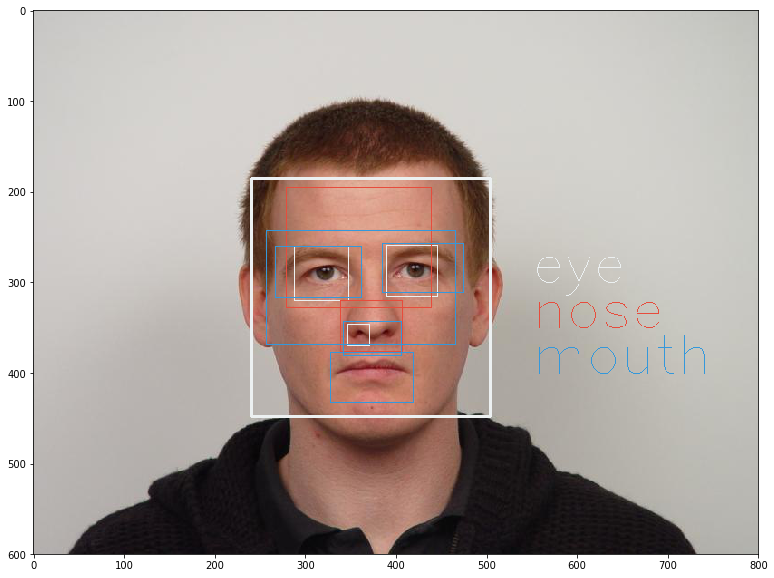

PICTURE ID.:65
-------------------- EYES -------------------------
[17.300380228136884, -11.216730038022813] 4.53382295537
[-20.722433460076044, -10.076045627376425] 5.20464369877
[-5.1330798479087454, 15.779467680608365] 0.832742991803
-------------------- NOSE -------------------------
[-5.1330798479087454, -20.912547528517113] 30.7652271972
[0.19011406844106463, 11.977186311787072] 5.50535644581
-------------------- MOUTH -------------------------
[0.57034220532319391, 17.300380228136884] 3.51602596539
[21.863117870722434, -12.357414448669202] 7.02626899334
[-22.053231939163499, -10.646387832699618] 7.82865156356
[-4.1825095057034218, -4.1825095057034218] 37.7698101751
[0.38022813688212925, 33.460076045627375] 7.23590047565


In [80]:
# import random
imageindex = random.randint(0,len(detected_images))
showImage(drawImageDetection(detected_images[imageindex].image,detected_images[imageindex].result,features))
print('PICTURE ID.:'+str(imageindex))
print('-------------------- EYES -------------------------')
for eye in detected_images[imageindex].result[0][0]:
    print(eye.relative_midpoint_percentage,eye.relative_size_percentage)
print('-------------------- NOSE -------------------------')
for nose in detected_images[imageindex].result[0][1]:
    print(nose.relative_midpoint_percentage,nose.relative_size_percentage)
print('-------------------- MOUTH -------------------------')
for mouth in detected_images[imageindex].result[0][2]:
    print(mouth.relative_midpoint_percentage,mouth.relative_size_percentage)

# let's grade our classifier
---
corresponding variable: `detected_images (list of class DetectedImage)` <br>
note: `DetectedImage: class` holding `image_name, image, result`

In [82]:
detected_images